In [1]:
import pandas as pd
import numpy as np
import pickle as pcl

from scipy.stats import binned_statistic

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

from palettable.tableau import GreenOrange_12
cmap = GreenOrange_12.hex_colors

from astropy.cosmology import Planck13, z_at_value
import astropy.units as u

from methods import normalise_coods
from methods import z_distort
from methods import factor_h
from methods import bhattacharyya

from overdensity_cylinder import overdensity_cylinder

h = 0.673
L = 480.279 / h

c = 2.97e8 # m s^-1

directory = '/lustre/scratch/astro/cl478/protoclusters_data/'
# directory = '/cosma/home/dp004/dc-love2/gpfs/protoclusters_data/'

In [2]:
redshifts = ['2p07','3p10','3p95','5p03','5p92','6p97','8p22','8p93','9p72']
zees = [float(z.replace('p','.')) for z in redshifts]

In [3]:
gals_sfr = [None] * len(redshifts)
gals_mstar = [None] * len(redshifts)

for i, (z, zed) in enumerate(zip(redshifts,zees)):  
    gals_sfr[i] = z_distort(factor_h(pd.read_csv('%shenriques2015a_z%s_sfr_r200.csv'%(directory,z), 
                              skiprows=122, skipfooter=1, engine='python'), h), zed, L)
    
    gals_mstar[i] = z_distort(factor_h(pd.read_csv('%shenriques2015a_z%s_stellarMass_r200.csv'%(directory,z), 
                                skiprows=122, skipfooter=1, engine='python'), h), zed, L)
    
    for gals in [gals_sfr, gals_mstar]:
        #         print "Filling in NaN values..."
        gals[i].ix[np.isnan(gals[i]['z0_haloId']), 'z0_haloId'] = -1
        gals[i].ix[np.isnan(gals[i]['z0_centralId']), 'z0_centralId'] = -1
        gals[i].ix[np.isnan(gals[i]['z0_central_mcrit200']), 'z0_central_mcrit200'] = 0

/mnt/pact/cl478/protoclusters/protoclusters/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


### AGN luminosity functions

Hopkins+06 fits

In [4]:
def H06(x, z=0,hubble_units=0,**kwargs):
    """
    Inputs: xmin, xmax - range along x-axis
            z - redshift
            *args - optional plotting arguments
    """

    h100=0.7
    phi_star=10.**(-4.825) #/h100**3
    zref=2.
    log10L_star0=13.036  # L_star is in Lsun
    kL1=0.632
    kL2=-11.76
    kL3=-14.25
    gamma10=0.417
    kg1=-0.623
    gamma20=2.174
    kg21=1.460
    kg22=-0.793
    
    eps=np.log10((1+z)/(1+zref))
    x_star=log10L_star0+kL1*eps+kL2*eps**2+kL3*eps**3
    if hubble_units==2: x_star=x_star+2*np.log10(h100)
    xx=10.**(x-x_star)
    gamma1=gamma10*10.**(eps*kg1)
    gamma2=2.*gamma20/(10.**(eps*kg21)+10.**(eps*kg22))
    y=phi_star/(xx**gamma1+xx**gamma2)
    if hubble_units==1 or hubble_units==2: y=y/h100**3
    return y


In [5]:
def accr_to_lbol(accr, sol=True, epsilon=0.1):
    lbol = accr / (365.25*24*60*60) * c**2 * epsilon * 1.989e30 * 1e7
    if sol: lbol /= 3.9e33
    return lbol

In [6]:
BinLimits = np.linspace(7, 15, 41)
Bins = np.linspace(7.1, 14.9, 40)

print BinLimits
print Bins

[  7.    7.2   7.4   7.6   7.8   8.    8.2   8.4   8.6   8.8   9.    9.2
   9.4   9.6   9.8  10.   10.2  10.4  10.6  10.8  11.   11.2  11.4  11.6
  11.8  12.   12.2  12.4  12.6  12.8  13.   13.2  13.4  13.6  13.8  14.
  14.2  14.4  14.6  14.8  15. ]
[  7.1   7.3   7.5   7.7   7.9   8.1   8.3   8.5   8.7   8.9   9.1   9.3
   9.5   9.7   9.9  10.1  10.3  10.5  10.7  10.9  11.1  11.3  11.5  11.7
  11.9  12.1  12.3  12.5  12.7  12.9  13.1  13.3  13.5  13.7  13.9  14.1
  14.3  14.5  14.7  14.9]


/mnt/pact/cl478/protoclusters/protoclusters/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/mnt/pact/cl478/protoclusters/protoclusters/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/mnt/pact/cl478/protoclusters/protoclusters/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10


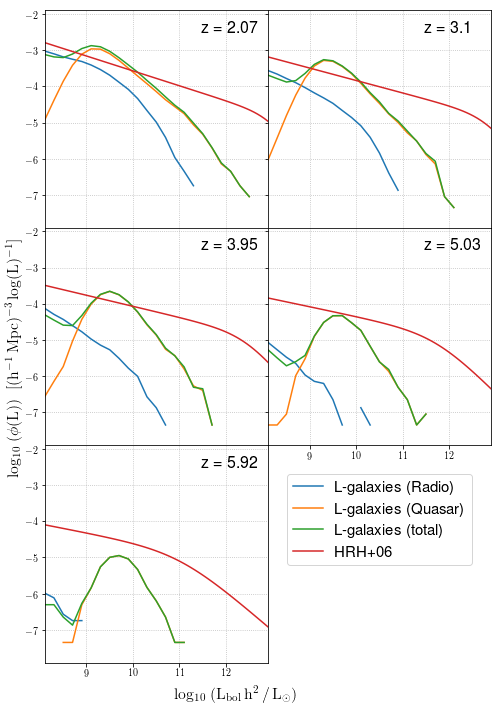

In [32]:
fig = plt.figure(figsize=(8,12))#, dpi=200)

gs = gridspec.GridSpec(3,2)

gs.update(hspace=0, wspace=0) # bottom = 0.57, top = 1,

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[2,0])

axes = [ax1,ax2,ax3,ax4,ax5]

for i, ax in zip(range(5), axes):
    
    total_accr =  gals[i]['zn_radioAccretionRate'] + gals[i]['zn_quasarAccretionRate']
    total_accr = total_accr[total_accr > 0.]
    
    radio_accr =  gals[i]['zn_radioAccretionRate']
    radio_accr = radio_accr[radio_accr > 0.]
    
    quasar_accr =  gals[i]['zn_quasarAccretionRate']
    quasar_accr = quasar_accr[quasar_accr > 0.]
    
    Lbol = accr_to_lbol(radio_accr)
    phi, bins = np.histogram(np.log10(Lbol * h**2), bins=BinLimits)
    phi = phi / (L*h)**3 / (BinLimits[1] - BinLimits[0])
    ax.plot(Bins, np.log10(phi), label='L-galaxies (Radio)')
    
    Lbol = accr_to_lbol(quasar_accr)
    phi, bins = np.histogram(np.log10(Lbol * h**2), bins=BinLimits)
    phi = phi / (L*h)**3 / (BinLimits[1] - BinLimits[0])
    ax.plot(Bins, np.log10(phi), label='L-galaxies (Quasar)')
    
    Lbol = accr_to_lbol(total_accr)
    phi, bins = np.histogram(np.log10(Lbol * h**2), bins=BinLimits)
    phi = phi / (L*h)**3 / (BinLimits[1] - BinLimits[0])
    ax.plot(Bins, np.log10(phi), label='L-galaxies (total)')

    x = np.linspace(6,13.5,num=101)
    H06_fit = H06(x, z=zees[i], hubble_units=0)
    ax.plot(x, np.log10(H06_fit), label='HRH+06')
    # plot_H06(6, 15, z=zees[i])

    ax.text(0.7, 0.9, 'z = %s'%zees[i], transform=ax.transAxes, size=16)

    ax.set_xlim(8.1, 12.9)
    ax.set_ylim(-7.9, -1.9)

    ax.grid(alpha=0.9, linestyle='dotted')


ax5.legend(bbox_to_anchor=(1.95, 0.9), prop={'size': 15})

for ax in [ax2, ax4]:
    ax.set_yticklabels([])
    
    
fig.text(0.35, 0.08, '$\mathrm{log_{10} \; (L_{bol} \, h^{2} \,/\, L_{\odot})}$', 
         size=16, transform=fig.transFigure)

fig.text(0.06, 0.6, '$\mathrm{log_{10} \; (\phi(L)) \;\; [(h^{-1} \, Mpc)^{-3} \, log(L)^{-1}] }$', 
         size=16, transform=fig.transFigure, rotation=90)

# fig.savefig('../images/Lgals_agn_LF.png', dpi=300)

Integrate LF to give number densities

In [18]:
from scipy.integrate import quad
# from scipy.integrate import trapz

i = 0
print zees[i]

quad(H06, 11.0, np.inf, zees[i], hubble_units)[0]

2.07


/mnt/pact/cl478/protoclusters/protoclusters/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in double_scalars
/mnt/pact/cl478/protoclusters/protoclusters/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars


9.177986020554424e-05

Evolution of number density:

/mnt/pact/cl478/protoclusters/protoclusters/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in double_scalars
/mnt/pact/cl478/protoclusters/protoclusters/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars


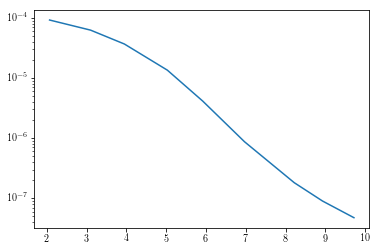

In [30]:
plt.semilogy(zees, [quad(H06, 11.0, np.inf, z)[0] for z in zees])

In [19]:
total_accr =  gals[i]['zn_radioAccretionRate'] # + gals[i]['zn_quasarAccretionRate']
Lbol = accr_to_lbol(total_accr[total_accr > 0.])

phi, bins = np.histogram(np.log10(Lbol * h**2), bins=BinLimits)
phi = phi / (L*h)**3 / (BinLimits[1] - BinLimits[0])
trapz(phi[Bins > 9.5], Bins[Bins > 9.5])

4.6048670705512847e-05

/mnt/pact/cl478/protoclusters/protoclusters/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/mnt/pact/cl478/protoclusters/protoclusters/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/mnt/pact/cl478/protoclusters/protoclusters/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


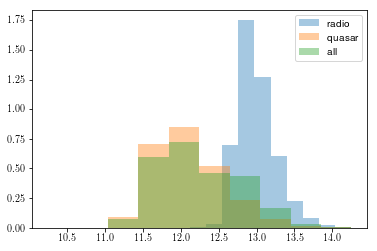

In [20]:
total_accr =  gals[i]['zn_radioAccretionRate'] #+ gals[i]['zn_quasarAccretionRate']
Lbol = np.log10(accr_to_lbol(total_accr))

plt.hist(np.log10(gals[i]['zn_mvir'][Lbol > 9.5] * 1e10), alpha=0.4, normed=True, label='radio');

total_accr = gals[i]['zn_quasarAccretionRate']
Lbol = np.log10(accr_to_lbol(total_accr))

plt.hist(np.log10(gals[i]['zn_mvir'][Lbol > 9.5] * 1e10), alpha=0.4, normed=True, label='quasar');

total_accr =  gals[i]['zn_radioAccretionRate'] + gals[i]['zn_quasarAccretionRate']
Lbol = np.log10(accr_to_lbol(total_accr))

plt.hist(np.log10(gals[i]['zn_mvir'][Lbol > 9.5] * 1e10), alpha=0.4, normed=True, label='all');

plt.legend()

Accretion rate distributions

(1e-08, 0.01)

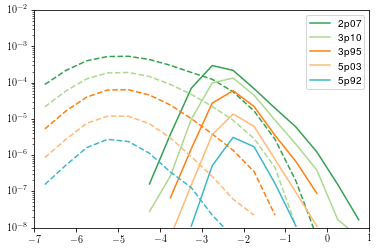

In [22]:
massBinLimits = np.linspace(-7, 1, 17)
massBins = np.linspace(-6.75, 0.75, 16)

for i in range(5):
    
    ### Quasar ###
    quasar_accr = gals[i]['zn_quasarAccretionRate'] #/ (365.25*24*60*60) * c**2 * epsilon * 1e7
    quasar_accr = quasar_accr[quasar_accr > 0.]
    
    phi, bins = np.histogram(np.log10(quasar_accr), bins=massBinLimits)
    phi = phi / L**3 / (massBinLimits[1] - massBinLimits[0])
    plt.semilogy(massBins, phi, label=redshifts[i], c=cmap[i])

    ### Radio ###
    radio_accr = gals[i]['zn_radioAccretionRate'] #/ (365.25*24*60*60) * c**2 * epsilon * 1e7
    radio_accr = radio_accr[radio_accr > 0.]
    
    phi, bins = np.histogram(np.log10(radio_accr), bins=massBinLimits)
    phi = phi / L**3 / (massBinLimits[1] - massBinLimits[0])
    plt.semilogy(massBins, phi, c=cmap[i], linestyle='dashed')#label=redshiftz[i],
    
    
plt.legend()
plt.xlim(massBinLimits[0],massBinLimits[-1])

plt.vlines(13, 1e-8, 1e-2, linestyle='dashed', color='grey', alpha=0.5)
plt.ylim(1e-8,1e-2)